<a href="https://colab.research.google.com/github/imumar/RottenTomatoAnalysisNLP/blob/main/NLP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Rotten tomatoes movie reviews sentiment analysis**

# Linking Kaggle account

In [ ]:
import os
import numpy as np
os.environ['KAGGLE_USERNAME'] = "umarlo" # username from the json file
os.environ['KAGGLE_KEY'] = "f7735dd6f011c5b3dc1c7b6725fb57cf" # key from the json file

# Exploration of dataset

Downloading the dataset and unzipping its contents

In [ ]:
!kaggle datasets download -d stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset

 87% 67.0M/77.2M [00:00<00:00, 63.9MB/s]
100% 77.2M/77.2M [00:00<00:00, 113MB/s] 


In [ ]:
!unzip '/content/rotten-tomatoes-movies-and-critic-reviews-dataset.zip'

Archive:  /content/rotten-tomatoes-movies-and-critic-reviews-dataset.zip
  inflating: rotten_tomatoes_critic_reviews.csv  
  inflating: rotten_tomatoes_movies.csv  


In [ ]:
import pandas as pd
Reviewdata = pd.read_csv('/content/rotten_tomatoes_critic_reviews.csv')

In [ ]:
Reviewdata.shape

(1130017, 8)

In [ ]:
Reviewdata.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [ ]:
Reviewdata['review_type'].value_counts()

Fresh     720210
Rotten    409807
Name: review_type, dtype: int64

Percentage for default

Fresh     63.73
Rotten    36.27
Name: review_type, dtype: float64


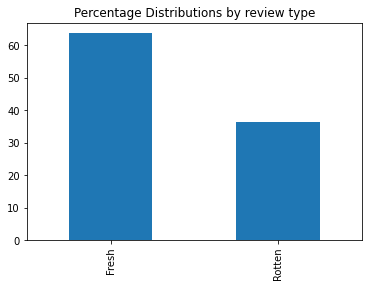

In [ ]:
import matplotlib.pyplot as plt

print('Percentage for default\n')
print(round(Reviewdata.review_type.value_counts(normalize=True)*100,2))
round(Reviewdata.review_type.value_counts(normalize=True)*100,2).plot(kind='bar')
plt.title('Percentage Distributions by review type')
plt.show()

Preprocessing

In [ ]:
Reviewdata.drop(['top_critic','rotten_tomatoes_link','publisher_name','review_date','critic_name','review_score'], axis=1, inplace=True)
Reviewdata.shape

(1130017, 2)

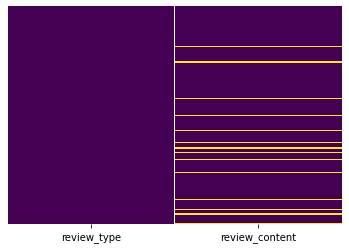

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(Reviewdata.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
features = ['review_content']
any_nan = Reviewdata[Reviewdata[features].isnull().any(axis=1)]
indeces = list(any_nan.index)
Reviewdata = Reviewdata.drop(Reviewdata.index[indeces])
print(Reviewdata.shape)

(1064211, 2)


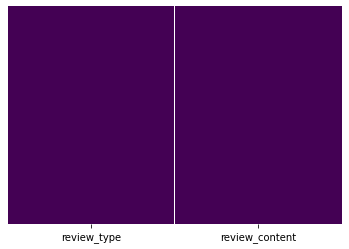

In [ ]:
sns.heatmap(Reviewdata.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
Reviewdata.drop_duplicates(subset=['review_content'], inplace=True)
print(Reviewdata.shape)

(949181, 2)


In [ ]:
Reviewdata['review_type'].value_counts()

Fresh     607346
Rotten    341835
Name: review_type, dtype: int64

# Cleaning of text(tokenization, stop words removal, stemming, removing links, special characters and brackets)

In [ ]:
from bs4 import BeautifulSoup
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

en_stopwords = set(stopwords.words('english'))
ps = PorterStemmer()

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [ ]:
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

In [ ]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

In [ ]:
def getCleanedText(text):
  text = text.lower()
  tokens = tokenizer.tokenize(text)
  new_tokens = [token for token in tokens if token not in en_stopwords  ]

  stemmed_tokens = [ps.stem(tokens) for tokens in new_tokens]

  clean_text = " ".join(stemmed_tokens)

  return clean_text

In [ ]:
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text= remove_special_characters(text)
    text = getCleanedText(text)
    return text

In [ ]:
Reviewdata['review_content']=Reviewdata['review_content'].apply(denoise_text)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://cinefantastiqueonline.com/2008/09/16/film-review-amelie-2002/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.spiritualityandpractice.com/films/reviews/view/28172/captain-america-civil-war" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.

In [ ]:
Reviewdata.head(5)

,review_type,review_content
0,Fresh,fantasi adventur fuse greek mytholog contempor...
1,Fresh,uma thurman medusa gorgon coiffur writh snake ...
2,Fresh,topnotch cast dazzl special effect tide teen n...
3,Fresh,whether audienc get behind lightn thief hard p...
4,Rotten,what realli lack lightn thief genuin sens wond...


# Train test splitting

In [ ]:
X = Reviewdata.drop(['review_type'], axis=1)
Y = Reviewdata['review_type']

In [ ]:
X.shape

(949181, 1)

In [ ]:
Y.shape

(949181,)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
os =  RandomOverSampler(sampling_strategy=1)
X_new, Y_new= os.fit_resample(X,Y)


Percentage for default

Fresh     50.0
Rotten    50.0
Name: review_type, dtype: float64


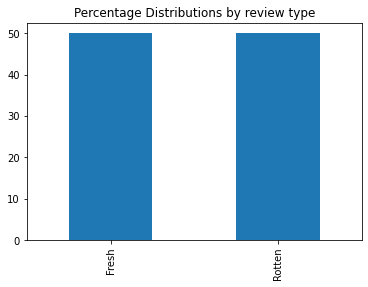

In [ ]:
print('Percentage for default\n')
print(round(Y_new.value_counts(normalize=True)*100,2))
round(Y_new.value_counts(normalize=True)*100,2).plot(kind='bar')
plt.title('Percentage Distributions by review type')
plt.show()

In [ ]:
X_new.shape

(1214692, 1)

In [ ]:
Y_new.shape

(1214692,)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X_new,Y_new,test_size=0.30,shuffle=True,random_state=42)

In [ ]:
X_train_txt= X_train.review_content
X_test_txt= X_test.review_content

In [ ]:
X_train_txt

123372     make wonder adventur adapt time quit thrill on...
614500     ambiti simplemind pleasantvil combin technic s...
392833                      anyon need reason boycott easter
50587      old stori find mr right show take familiar tal...
1000628    writer wesley stick director daniel sackheim d...
                                 ...                        
110268     although difficult awar christoph plummer last...
259178     comedi favor mania wit requir high toler sh di...
131932     part respons stanley kubrick headi masterpiec ...
671155                     heart humour countdown armageddon
121958     marit crisi movi heart lost allegor weight jan...
Name: review_content, Length: 850284, dtype: object

# Vectorization and model building

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.pipeline import Pipeline

In [ ]:
tvec = TfidfVectorizer()
clf = LogisticRegression(solver='lbfgs', max_iter=1000)

model = Pipeline([('vectorizer', tvec), ('classifier', clf)])

In [ ]:
model.fit(X_train_txt,Y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression(max_iter=1000))])

In [ ]:
Y_pred = model.predict(X_test_txt)
Accuracy_model = accuracy_score(Y_pred, Y_test)

In [ ]:
Accuracy_model

0.8024000570788786

In [ ]:
model_report = classification_report(Y_test,Y_pred,target_names=['Fresh','Rotten'])
print(model_report)

              precision    recall  f1-score   support

       Fresh       0.80      0.80      0.80    182244
      Rotten       0.80      0.80      0.80    182164

    accuracy                           0.80    364408
   macro avg       0.80      0.80      0.80    364408
weighted avg       0.80      0.80      0.80    364408



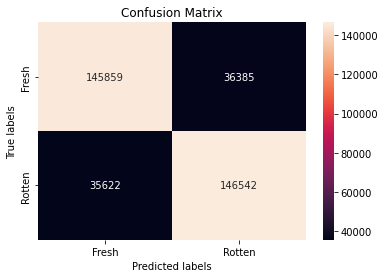

In [ ]:
import seaborn as sns

ax= plt.subplot()
sns.heatmap(model_cf, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Fresh', 'Rotten']);
ax.yaxis.set_ticklabels(['Fresh', 'Rotten']);

In [ ]:
from sklearn.naive_bayes import MultinomialNB

tvec = TfidfVectorizer()
clf = MultinomialNB()

model1 = Pipeline([('vectorizer', tvec), ('classifier', clf)])

In [ ]:
model1.fit(X_train_txt,Y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', MultinomialNB())])

In [ ]:
Y_pred1 = model1.predict(X_test_txt)
Accuracy_model1 = accuracy_score(Y_pred1, Y_test)


In [ ]:
Accuracy_model1

0.7911626528506509

In [ ]:
model1_report = classification_report(Y_test,Y_pred1,target_names=['Fresh','Rotten'])
print(model1_report)

              precision    recall  f1-score   support

       Fresh       0.79      0.79      0.79    182244
      Rotten       0.79      0.80      0.79    182164

    accuracy                           0.79    364408
   macro avg       0.79      0.79      0.79    364408
weighted avg       0.79      0.79      0.79    364408



In [ ]:
model1_cf=confusion_matrix(Y_test,Y_pred1,labels=['Fresh','Rotten'])
print(model1_cf)

[[143193  39051]
 [ 37051 145113]]


In [ ]:
from xgboost import XGBClassifier

tvec = TfidfVectorizer()
clf = XGBClassifier()

model2 = Pipeline([('vectorizer', tvec), ('classifier', clf)])

In [ ]:
model2.fit(X_train_txt,Y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', XGBClassifier())])

In [ ]:
Y_pred2 = model2.predict(X_test_txt)
Accuracy_model2 = accuracy_score(Y_pred2, Y_test)


In [ ]:
Accuracy_model2

0.6530839059515707

In [ ]:
model2_report = classification_report(Y_test,Y_pred2,target_names=['Fresh','Rotten'])
print(model2_report)

              precision    recall  f1-score   support

       Fresh       0.71      0.53      0.60    182244
      Rotten       0.62      0.78      0.69    182164

    accuracy                           0.65    364408
   macro avg       0.66      0.65      0.65    364408
weighted avg       0.66      0.65      0.65    364408



In [ ]:
model2_cf=confusion_matrix(Y_test,Y_pred2,labels=['Fresh','Rotten'])
print(model2_cf)

[[ 95825  86419]
 [ 40000 142164]]


In [ ]:
X_train_arr=np.array(X_train_txt.values.tolist())
Y_train_arr=np.array(Y_train.values.tolist())
X_test_arr=np.array(X_test_txt.values.tolist())
Y_test_arr=np.array(Y_test.values.tolist())

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
Y_test_enc= label_encoder.fit_transform(Y_test_arr)

In [ ]:
Y_train_enc= label_encoder.fit_transform(Y_train_arr)

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM, Dense, Dropout, Flatten

In [ ]:
pretrained_model = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(pretrained_model, input_shape=[], dtype=tf.string, trainable=True)


In [ ]:
model3 = tf.keras.Sequential()
model3.add(hub_layer)
model3.add(Dropout(0.3))
model3.add(tf.keras.layers.Dense(1,activation="sigmoid"))
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 400,041
Trainable params: 400,041
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
tf.config.run_functions_eagerly(True)


In [ ]:
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)


In [ ]:
hist = model3.fit(X_train_arr, Y_train_enc,batch_size=512, epochs=8,validation_data=(X_test_arr, Y_test_enc),callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/8
1661/1661 [==============================] - ETA: 0s - loss: 0.6259 - accuracy: 0.6485
Epoch 00001: val_accuracy improved from -inf to 0.70937, saving model to best_model.hdf5
1661/1661 [==============================] - 75s 44ms/step - loss: 0.6259 - accuracy: 0.6485 - val_loss: 0.5654 - val_accuracy: 0.7094
Epoch 2/8
1660/1661 [============================>.] - ETA: 0s - loss: 0.5768 - accuracy: 0.6952
Epoch 00002: val_accuracy improved from 0.70937 to 0.71277, saving model to best_model.hdf5
1661/1661 [==============================] - 72s 43ms/step - loss: 0.5768 - accuracy: 0.6952 - val_loss: 0.5584 - val_accuracy: 0.7128
Epoch 3/8
1660/1661 [============================>.] - ETA: 0s - loss: 0.5698 - accuracy: 0.7018
Epoch 00003: val_accuracy improved from 0.71277 to 0.71344, saving model to best_model.hdf5
1661/1661 [==============================] - 82s 50ms/step - loss: 0.5698 - accuracy: 0.7018 - val_loss: 0.5565 - val_accuracy: 0.7134
Epoch 4/8
1660/1661 [==========

In [ ]:
h = hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
best_accuracy = max(h['accuracy'])
print("best training accuracy",best_accuracy *100,"%")

best training accuracy 70.97722887992859 %


In [ ]:
cc=model3.predict(["best movie ever","bad movie"])
cc

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


array([[0.1055826],
       [0.8933727]], dtype=float32)

In [ ]:
Y_pred3=model3.predict(X_test_arr)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
Y_pred3_round = np.rint(Y_pred3)
Y_pred3_round

array([[0.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [0.]], dtype=float32)

In [ ]:
Accuracy_model3 = accuracy_score(Y_pred3_round, Y_test_enc)
Accuracy_model3

0.7137384470154332

In [ ]:
model3_report = classification_report(Y_test_enc,Y_pred3_round,target_names=['0','1'])
print(model3_report)

              precision    recall  f1-score   support

           0       0.72      0.69      0.71    182244
           1       0.70      0.74      0.72    182164

    accuracy                           0.71    364408
   macro avg       0.71      0.71      0.71    364408
weighted avg       0.71      0.71      0.71    364408



# LSTM

In [ ]:
# max_words = 5000

In [ ]:
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# max_words = 5000
# max_len = 20

# tokenizer = Tokenizer(num_words=max_words)
# tokenizer.fit_on_texts(X_train_arr)
# sequences_X_train = tokenizer.texts_to_sequences(X_train_arr)
# X_train_tk = pad_sequences(sequences_X_train, maxlen=max_len)
# print(X_train_tk)

In [ ]:
# tokenizer.fit_on_texts(X_test_arr)
# sequences_X_test = tokenizer.texts_to_sequences(X_test_arr)
# X_test_tk = pad_sequences(sequences_X_test, maxlen=max_len)

In [ ]:
# X_train_tk[:1]

In [ ]:
# from keras.layers import Embedding


In [ ]:
# from keras.models import Sequential
# from keras import layers
# from keras.layers import Dense, Flatten

# from keras.callbacks import ModelCheckpoint

In [ ]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout, Flatten

# model3 = Sequential()
# model3.add(Embedding(max_words, 40, input_length=max_len))
# model3.add(Dropout(0.3))
# model3.add(LSTM(100))
# model3.add(Dropout(0.3))
# model3.add(Dense(1,activation='sigmoid'))
# model3.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
# model3.summary()


In [ ]:
# checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)


In [ ]:
# hist = model3.fit(X_train_tk, Y_train_enc,batch_size=256, epochs=8,validation_data=(X_test_tk, Y_test_enc),callbacks=[checkpoint])

# Word cloud

In [ ]:
from wordcloud import WordCloud

In [ ]:
positive_reviews=Reviewdata[Reviewdata['review_type']=='Fresh']
negative_reviews=Reviewdata[Reviewdata['review_type']=='Rotten']

In [ ]:
def wc(data,bgcolor,title):
    plt.figure(figsize = (20,20))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

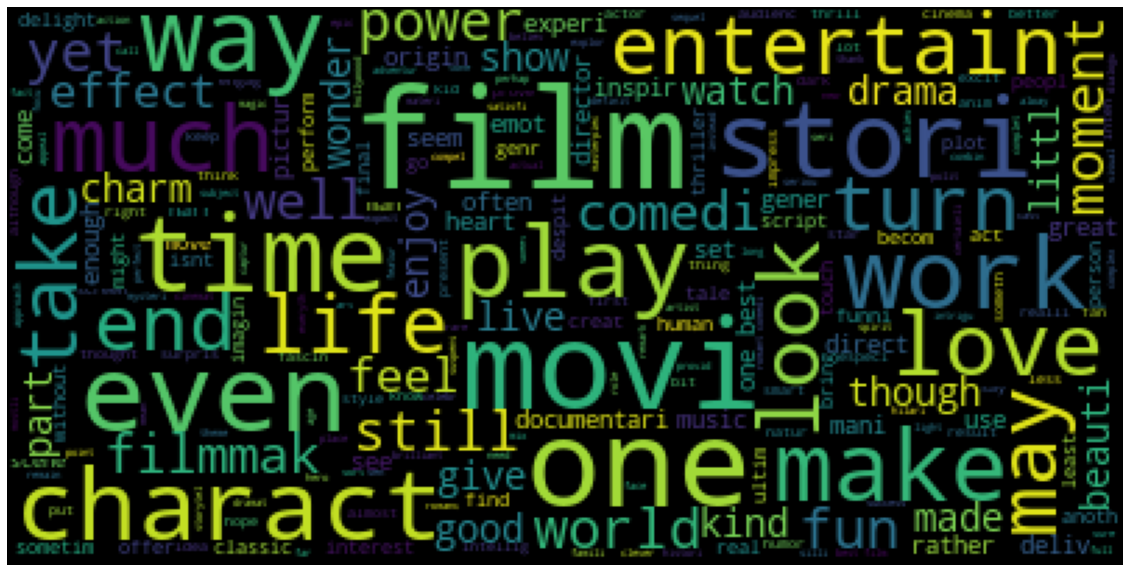

In [ ]:
wc(positive_reviews['review_content'],'black','Most Used Words')


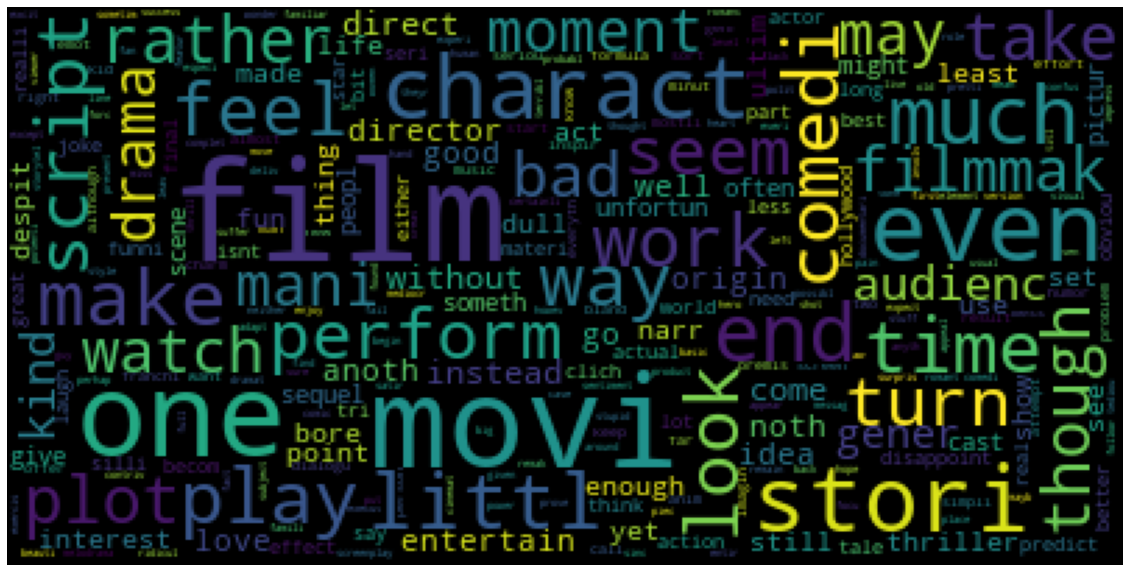

In [ ]:
wc(negative_reviews['review_content'],'black','Most Used Words')

# Model Performance Summary

In [ ]:
model_performance_accuracy = pd.DataFrame({'Model': ['model',
                                                      'model1',
                                                      'model2',
                                                      'model3',
                                                      ],
                                            'Accuracy': [Accuracy_model,
                                                         Accuracy_model1,
                                                         Accuracy_model2,
                                                         Accuracy_model3]})

In [ ]:
model_performance_accuracy.sort_values(by = "Accuracy", ascending = False)

,Model,Accuracy
0,model,0.802990
1,model1,0.791163
3,model3,0.713738
2,model2,0.653084
